## Visualize the features included in the signature

Gregory Way, 2021

The bortezomib resistance signature contains a handful of CellProfiler-derived morphology features.
Visualize these features here.


### Visualizations

* The distribution of feature values according to linear models
* Heatmap of signature feature correlation in the validation set
* Heatmap of all feature correlations in the validation set

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(heatmap3))

source(file.path("utils", "viz.R"))

In [2]:
seed <- 1234
set.seed(seed)

dataset <- "bortezomib"

signature_dir <- file.path("results", "signatures")
data_dir <- "data"

anova_file <- file.path(signature_dir, paste0("anova_results_", dataset, "_signature.tsv.gz"))
tukey_file <- file.path(signature_dir, paste0("tukey_results_", dataset, "_signature.tsv.gz"))
cell_count_file <- file.path(signature_dir, paste0("lm_cell_count_results_", dataset, "_signature.tsv.gz"))
summary_file <- file.path(signature_dir, paste0("signature_summary_", dataset, "_signature.tsv.gz"))

data_file <- file.path(data_dir, "bortezomib_signature_analytical_set.tsv.gz")

output_fig_dir <- file.path("figures", "signature_features")

In [3]:
# Load data
anova_cols <- readr::cols(
    term = readr::col_character(),
    df = readr::col_integer(),
    sumsq = readr::col_double(),
    meansq = readr::col_double(),
    statistic = readr::col_double(),
    p.value = readr::col_double(),
    feature = readr::col_character(),
    neg_log_p = readr::col_double(),
    dataset = readr::col_character()
)

anova_df <- readr::read_tsv(anova_file, col_types = anova_cols)

tukey_cols <- readr::cols(
    term = readr::col_character(),
    comparison = readr::col_character(),
    estimate = readr::col_double(),
    conf.low = readr::col_double(),
    conf.high = readr::col_double(),
    adj.p.value = readr::col_double(),
    feature = readr::col_character(),
    neg_log_adj_p = readr::col_double(),
    dataset = readr::col_character()
)

tukey_df <- readr::read_tsv(tukey_file, col_types = tukey_cols)

cell_count_cols <- readr::cols(
    term = readr::col_character(),
    estimate = readr::col_double(),
    std.error = readr::col_double(),
    statistic = readr::col_double(),
    p.value = readr::col_double(),
    feature = readr::col_character(),
    rsquared = readr::col_double(),
    neg_log_p = readr::col_double()
)

cell_count_df <- readr::read_tsv(cell_count_file, col_types = cell_count_cols)

summary_cols <- readr::cols(
    features = readr::col_character(),
    non_status_significant_exclude = readr::col_character(),
    cell_count_exclude = readr::col_character(),
    batch_exclude = readr::col_character(),
    non_specific_exclude = readr::col_character(),
    final_signature = readr::col_character(),
    dataset = readr::col_character()
)

summary_df <- readr::read_tsv(summary_file, col_types = summary_cols)

In [4]:
# Recode the factors in plotting datasets for improved viz
recode_terms <- c(
    "Metadata_batch" = "Batch",
    "Metadata_clone_number" = "Within same clone type",
    "Metadata_clone_type_indicator" = "Resistance status",
    "scale(Metadata_cell_count)" = "Cell count",
    "Metadata_treatment_time" = "Treatment time"
)

anova_df$term <- dplyr::recode(anova_df$term, !!!recode_terms)
cell_count_df$term <- dplyr::recode(cell_count_df$term, !!!recode_terms)
tukey_df$term <- dplyr::recode(tukey_df$term, !!!recode_terms)

# Set colors and labels
term_labels = c(
    "Batch" = "Batch",
    "Within same clone type" = "Within same clone type",
    "Resistance status" = "Resistance status",
    "Cell count" = "Cell count",
    "Plate" = "Plate",
    "Treatment time" = "Treatment time"
)
term_values = c(
    "Batch" = "#75BE3A",
    "Within same clone type" = "#EF7333",
    "Resistance status" = "#146CB1",
    "Cell count" = "black",
    "Plate" = "#301B65",
    "Treatment time" = "purple"
)

In [5]:
# Identify significance line
num_cp_features <- length(unique(anova_df$feature))
signif_line <- -log10(0.05 / num_cp_features)
signif_line

[1] 4.194237

In [6]:
# Get the final resistance status signature features
final_sig <- summary_df %>%
    dplyr::filter(
        dataset == !!dataset,
        final_signature == "TRUE"
    ) %>%
    dplyr::pull(features)

## Plot 1 - Covariate contribution to sensitivity

In [7]:
# Split features into categories
tukey_subset_df <- tukey_df %>%
    tidyr::separate(
        feature,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(compartment_feature_group = paste(compartment, feature_group, channel, sep=" - "))

tukey_subset_df <- tukey_subset_df %>%
    dplyr::mutate(in_signature = feature %in% final_sig)

# Call infinite values the max (for plotting only)
max_val <- max(tukey_subset_df$neg_log_adj_p[!is.infinite(tukey_subset_df$neg_log_adj_p)])
tukey_subset_df[is.infinite(tukey_subset_df$neg_log_adj_p), "neg_log_adj_p"] <- max_val

# Split off the biological factor we want to isolate
status_subset_df <- tukey_subset_df %>% dplyr::filter(term == "Resistance status")
no_status_subset_df <- tukey_subset_df %>% dplyr::filter(term != "Resistance status")

# Determine if the clone number comparison is between like-clones
wt_clone_count <- stringr::str_count(
    no_status_subset_df %>%
    dplyr::filter(term == "Within same clone type") %>%
    dplyr::pull("comparison"), "WT"
)

clone_id_feature_drop <- no_status_subset_df %>%
    dplyr::filter(term == "Within same clone type") %>%
    dplyr::mutate(wt_clone_count = wt_clone_count) %>%
    dplyr::filter(neg_log_adj_p > !!signif_line, wt_clone_count != 1) %>%
    dplyr::count(feature) %>%
    dplyr::arrange(desc(n)) %>%
    dplyr::filter(n > 1) %>%
    dplyr::pull(feature)

clone_id_unique_df <- no_status_subset_df %>%
    dplyr::filter(term == "Within same clone type") %>%
    dplyr::mutate(wt_clone_count = wt_clone_count) %>%
    dplyr::filter(!(feature %in% clone_id_feature_drop))

no_status_subset_df <- no_status_subset_df %>%
    dplyr::filter(term != "Within same clone type")

head(status_subset_df)

Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 32488 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”

term,comparison,estimate,conf.low,conf.high,adj.p.value,feature,compartment,feature_group,measurement,channel,parameter1,parameter2,neg_log_adj_p,dataset,compartment_feature_group,in_signature
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<lgl>
Resistance status,1-0,0.7807695,0.6615230,0.9000160,0,Nuclei_RadialDistribution_FracAtD_Mito_3of4,Nuclei,RadialDistribution,FracAtD,Mito,3of4,NA,15.95459,bortezomib,Nuclei - RadialDistribution - Mito,FALSE
Resistance status,1-0,-1.0526881,-1.1785522,-0.9268239,0,Cells_Texture_Correlation_Mito_20_03,Cells,Texture,Correlation,Mito,20,03,15.95459,bortezomib,Cells - Texture - Mito,FALSE
Resistance status,1-0,-1.0487589,-1.1720954,-0.9254225,0,Cells_Texture_Correlation_Mito_20_01,Cells,Texture,Correlation,Mito,20,01,15.95459,bortezomib,Cells - Texture - Mito,FALSE
Resistance status,1-0,1.5104162,1.3819653,1.6388670,0,Nuclei_RadialDistribution_FracAtD_ER_1of4,Nuclei,RadialDistribution,FracAtD,ER,1of4,NA,15.95459,bortezomib,Nuclei - RadialDistribution - ER,FALSE
Resistance status,1-0,-0.5415537,-0.6701393,-0.4129682,0,Cytoplasm_Texture_Correlation_AGP_10_01,Cytoplasm,Texture,Correlation,AGP,10,01,15.95459,bortezomib,Cytoplasm - Texture - AGP,FALSE
Resistance status,1-0,1.5931164,1.4564672,1.7297656,0,Nuclei_RadialDistribution_FracAtD_ER_2of4,Nuclei,RadialDistribution,FracAtD,ER,2of4,NA,15.95459,bortezomib,Nuclei - RadialDistribution - ER,FALSE


In [8]:
cell_count_subset_df <- cell_count_df %>%
    tidyr::separate(
        feature,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(compartment_feature_group = paste(compartment, feature_group, channel, sep=" - ")) %>%
    dplyr::filter(term == "Cell count") %>%
    dplyr::mutate(in_signature = feature %in% final_sig)

head(cell_count_subset_df)

Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 1572 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”

term,estimate,std.error,statistic,p.value,feature,compartment,feature_group,measurement,channel,parameter1,parameter2,rsquared,neg_log_p,dataset,compartment_feature_group,in_signature
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<lgl>
Cell count,0.3846991,0.03684746,10.440314,1.154095e-20,Nuclei_Neighbors_SecondClosestObjectNumber_2,Nuclei,Neighbors,SecondClosestObjectNumber,2,NA,NA,0.3826809,19.93776,bortezomib,Nuclei - Neighbors - 2,FALSE
Cell count,0.4413808,0.04860343,9.081268,1.016644e-16,Cytoplasm_Correlation_K_Mito_ER,Cytoplasm,Correlation,K,Mito,ER,NA,0.3532979,15.99283,bortezomib,Cytoplasm - Correlation - Mito,FALSE
Cell count,0.4761019,0.05463958,8.713500,1.094189e-15,Cells_Neighbors_AngleBetweenNeighbors_10,Cells,Neighbors,AngleBetweenNeighbors,10,NA,NA,0.3476261,14.96091,bortezomib,Cells - Neighbors - 10,FALSE
Cell count,-0.4380187,0.05118982,-8.556755,2.974426e-15,Cytoplasm_Correlation_K_ER_Mito,Cytoplasm,Correlation,K,ER,Mito,NA,0.3325260,14.52660,bortezomib,Cytoplasm - Correlation - ER,FALSE
Cell count,0.4716349,0.05514146,8.553180,3.042766e-15,Cells_Neighbors_PercentTouching_10,Cells,Neighbors,PercentTouching,10,NA,NA,0.3599217,14.51673,bortezomib,Cells - Neighbors - 10,FALSE
Cell count,0.3847641,0.04579469,8.401938,7.924018e-15,Nuclei_Texture_AngularSecondMoment_Mito_20_01,Nuclei,Texture,AngularSecondMoment,Mito,20,01,0.2904458,14.10105,bortezomib,Nuclei - Texture - Mito,FALSE


In [9]:
# Define which points to highlight
repel_logic <- (
    status_subset_df$dataset == dataset &
    status_subset_df$feature %in% final_sig
)

In [10]:
point_size <- 0.2
point_alpha <- 0.5
point_shape <- 1

main_effect_gg <- (
    ggplot(status_subset_df, aes(x = estimate, y = neg_log_adj_p))
    + geom_point(
        color = ifelse(repel_logic, "red", "darkgrey"),
        size = point_size,
        alpha = point_alpha,
        shape = point_shape
    )
    + geom_hline(yintercept = signif_line, linetype = "dashed", color = "red", lwd = 0.1)
    + ylim(c(0, max_val + 0.5))
    + custom_theme
    + ylab("-log10 p value")
    + xlab("Fold change")
    + facet_wrap("~term")
)

In [11]:
point_size = 0.05
point_alpha = 0.3
point_shape <- 1

covariate_gg <- (
    ggplot(no_status_subset_df, aes(x = estimate, y = neg_log_adj_p))
    + geom_point(
        aes(color = in_signature),
        size = point_size,
        alpha = 0,
        shape = point_shape
    )
    + geom_point(
        data = no_status_subset_df %>% dplyr::filter(!(feature %in% final_sig)),
        size = point_size,
        alpha = point_alpha,
        shape = point_shape
    )
    + geom_point(
        data = no_status_subset_df %>% dplyr::filter(feature %in% final_sig),
        color = "red",
        size = point_size,
        alpha = point_alpha,
        shape = point_shape
    )
    
    + geom_point(
        data = clone_id_unique_df %>% dplyr::filter(!(feature %in% final_sig)),
        size = point_size,
        alpha = point_alpha,
        shape = point_shape
    )
    + geom_point(
        data = clone_id_unique_df %>% dplyr::filter(feature %in% final_sig),
        color = "red",
        size = point_size,
        alpha = point_alpha,
        shape = point_shape
    )
    + geom_point(
        data = cell_count_subset_df %>% dplyr::filter(!(feature %in% final_sig)),
        aes(x = estimate, y = neg_log_p),
        size = point_size,
        alpha = point_alpha,
        shape = point_shape
    )
    + geom_point(
        data = cell_count_subset_df %>% dplyr::filter(feature %in% final_sig),
        aes(x = estimate, y = neg_log_p),
        color = "red",
        size = point_size,
        alpha = point_alpha,
        shape = point_shape
    )
    + scale_color_manual(
        name = "Bortezomib\nsensitivity\nsignature\nfeature",
        values = c("TRUE" = "red", "FALSE" = "black"),
        labels = c("TRUE" = "TRUE", "FALSE" = "FALSE")
    )
    + facet_wrap("~term", nrow = 2)
    + geom_hline(yintercept = signif_line, linetype = "dashed", color = "red", lwd = 0.1)
    + ylim(c(0, max_val + 0.5))
    + custom_theme
    + ylab("-log10 p value")
    + xlab("Fold change")
    + guides(color = guide_legend(override.aes = list(size = 1, alpha = point_alpha) ) )
)

Warning message:
“Removed 1 rows containing missing values (geom_point).”

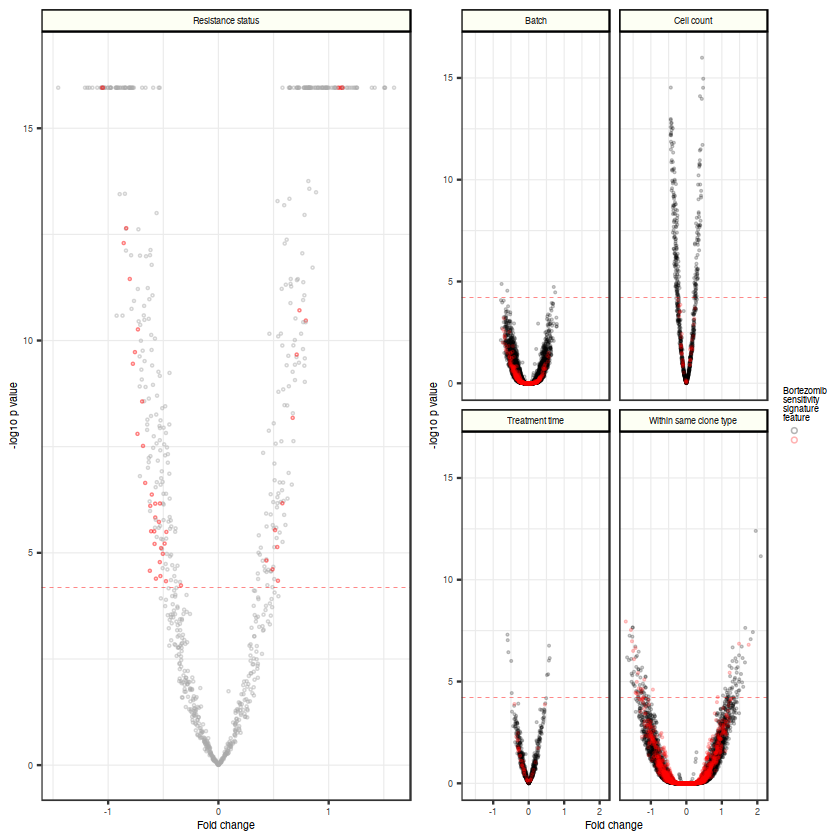

In [12]:
volcano_plot_gg <- cowplot::plot_grid(
    main_effect_gg,
    covariate_gg,
    ncol = 2,
    rel_widths = c(1, 1),
    align = "hv",
    axis = "l"
)

output_fig_file <- file.path(output_fig_dir, "bortezomib_signature_feature_volcano.png")
ggsave(output_fig_file, volcano_plot_gg, dpi = 500, height = 2.5, width = 5.25)

volcano_plot_gg

## What are the actual signature features?

In [13]:
final_sig_df <- status_subset_df %>%
    dplyr::filter(feature %in% final_sig) %>%
    dplyr::select(
        feature,
        compartment,
        feature_group,
        measurement,
        channel,
        estimate,
        neg_log_adj_p,
        compartment_feature_group
    )

head(final_sig_df)

feature,compartment,feature_group,measurement,channel,estimate,neg_log_adj_p,compartment_feature_group
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
Cells_RadialDistribution_RadialCV_ER_2of4,Cells,RadialDistribution,RadialCV,ER,1.085944,15.95459,Cells - RadialDistribution - ER
Nuclei_RadialDistribution_RadialCV_ER_1of4,Nuclei,RadialDistribution,RadialCV,ER,1.123878,15.95459,Nuclei - RadialDistribution - ER
Nuclei_RadialDistribution_MeanFrac_RNA_1of4,Nuclei,RadialDistribution,MeanFrac,RNA,1.108679,15.95459,Nuclei - RadialDistribution - RNA
Cytoplasm_Correlation_RWC_DNA_RNA,Cytoplasm,Correlation,RWC,DNA,-1.054877,15.95459,Cytoplasm - Correlation - DNA
Cytoplasm_RadialDistribution_MeanFrac_Mito_3of4,Cytoplasm,RadialDistribution,MeanFrac,Mito,1.126688,15.95459,Cytoplasm - RadialDistribution - Mito
Cells_Intensity_IntegratedIntensity_DNA,Cells,Intensity,IntegratedIntensity,DNA,-1.047289,15.95459,Cells - Intensity - DNA


In [14]:
sort(final_sig_df$feature)

[1] "Cells_AreaShape_Zernike_4_2"                    
 [2] "Cells_Correlation_K_DNA_AGP"                    
 [3] "Cells_Correlation_Manders_Mito_ER"              
 [4] "Cells_Correlation_Manders_Mito_RNA"             
 [5] "Cells_Intensity_IntegratedIntensity_DNA"        
 [6] "Cells_RadialDistribution_RadialCV_ER_2of4"      
 [7] "Cells_RadialDistribution_RadialCV_Mito_1of4"    
 [8] "Cells_RadialDistribution_RadialCV_RNA_2of4"     
 [9] "Cells_Texture_Correlation_Mito_10_00"           
[10] "Cells_Texture_Correlation_Mito_10_02"           
[11] "Cells_Texture_InfoMeas2_DNA_5_02"               
[12] "Cytoplasm_Correlation_K_AGP_DNA"                
[13] "Cytoplasm_Correlation_K_DNA_AGP"                
[14] "Cytoplasm_Correlation_Manders_ER_AGP"           
[15] "Cytoplasm_Correlation_Manders_ER_RNA"           
[16] "Cytoplasm_Correlation_Manders_RNA_AGP"          
[17] "Cytoplasm_Correlation_RWC_DNA_ER"               
[18] "Cytoplasm_Correlation_RWC_DNA_RNA"              
[19] "Cytoplasm_Correlation_RWC_Mito_ER"              
[20] "Cytoplasm_Granularity_2_AGP"                    
[21] "Cytoplasm_Intensity_IntegratedIntensityEdge_RNA"
[22] "Cytoplasm_Intensity_MassDisplacement_ER"        
[23] "Cytoplasm_Intensity_MassDisplacement_Mito"      
[24] "Cytoplasm_RadialDistribution_MeanFrac_Mito_3of4"
[25] "Cytoplasm_Texture_AngularSecondMoment_Mito_5_02"
[26] "Cytoplasm_Texture_InfoMeas2_Mito_5_00"          
[27] "Cytoplasm_Texture_InfoMeas2_Mito_5_01"          
[28] "Nuclei_AreaShape_Zernike_6_0"                   
[29] "Nuclei_AreaShape_Zernike_9_3"                   
[30] "Nuclei_Granularity_7_DNA"                       
[31] "Nuclei_RadialDistribution_MeanFrac_AGP_1of4"    
[32] "Nuclei_RadialDistribution_MeanFrac_AGP_2of4"    
[33] "Nuclei_RadialDistribution_MeanFrac_RNA_1of4"    
[34] "Nuclei_RadialDistribution_RadialCV_ER_1of4"     
[35] "Nuclei_RadialDistribution_RadialCV_RNA_2of4"    
[36] "Nuclei_Texture_Correlation_DNA_10_00"           
[37] "Nuclei_Texture_Correlation_DNA_10_02"           
[38] "Nuclei_Texture_Correlation_DNA_5_00"            
[39] "Nuclei_Texture_Correlation_Mito_10_00"          
[40] "Nuclei_Texture_Correlation_Mito_10_01"          
[41] "Nuclei_Texture_Correlation_Mito_10_02"          
[42] "Nuclei_Texture_Correlation_Mito_10_03"          
[43] "Nuclei_Texture_Correlation_RNA_10_01"           
[44] "Nuclei_Texture_Correlation_RNA_10_03"           
[45] "Nuclei_Texture_InfoMeas1_RNA_5_00"

In [15]:
profile_cols <- readr::cols(
    .default = readr::col_double(),
    Metadata_Plate = readr::col_character(),
    Metadata_Well = readr::col_character(),
    Metadata_batch = readr::col_character(),
    Metadata_cell_count = readr::col_integer(),
    Metadata_cell_density = readr::col_character(),
    Metadata_clone_number = readr::col_character(),
    Metadata_plate_map_name = readr::col_character(),
    Metadata_time_to_adhere = readr::col_character(),
    Metadata_treatment = readr::col_character(),
    Metadata_treatment_time = readr::col_character(),
    Metadata_dataset = readr::col_character(),
    Metadata_clone_type = readr::col_character(),
    Metadata_clone_type_indicator = readr::col_integer(),
    Metadata_model_split = readr::col_character(),
    Metadata_unique_sample_name = readr::col_character()
)

profiles_df <- readr::read_tsv(data_file, col_types = profile_cols) %>%
    dplyr::filter(Metadata_model_split == "validation")

In [16]:
feature_cor_df <- profiles_df %>%
    dplyr::select(!!final_sig_df$feature) %>%
    as.matrix() %>%
    cor()

head(feature_cor_df)

,Cells_RadialDistribution_RadialCV_ER_2of4,Nuclei_RadialDistribution_RadialCV_ER_1of4,Nuclei_RadialDistribution_MeanFrac_RNA_1of4,Cytoplasm_Correlation_RWC_DNA_RNA,Cytoplasm_RadialDistribution_MeanFrac_Mito_3of4,Cells_Intensity_IntegratedIntensity_DNA,Nuclei_Texture_Correlation_DNA_10_02,Cytoplasm_Correlation_RWC_DNA_ER,Nuclei_Texture_Correlation_DNA_10_00,Cells_RadialDistribution_RadialCV_RNA_2of4,⋯,Nuclei_Texture_InfoMeas1_RNA_5_00,Nuclei_Texture_Correlation_Mito_10_02,Cells_Texture_Correlation_Mito_10_00,Nuclei_RadialDistribution_RadialCV_RNA_2of4,Cells_Texture_InfoMeas2_DNA_5_02,Nuclei_AreaShape_Zernike_6_0,Cytoplasm_Correlation_Manders_ER_RNA,Cytoplasm_Correlation_Manders_ER_AGP,Cells_Correlation_K_DNA_AGP,Cytoplasm_Correlation_Manders_RNA_AGP
Cells_RadialDistribution_RadialCV_ER_2of4,1.0000000,0.7352558,0.8102873,-0.5703355,0.5475114,-0.2098247,-0.07800450,-0.6549376,-0.09632660,0.8110095,⋯,-0.52933111,-0.18144622,-0.04472277,0.5204119,-0.01067684,0.53594365,-0.01886672,-0.14464140,0.3696098,-0.5553966
Nuclei_RadialDistribution_RadialCV_ER_1of4,0.7352558,1.0000000,0.4269708,-0.4681630,0.4270131,-0.4717491,-0.31100755,-0.4942243,-0.30698966,0.5029291,⋯,-0.05693873,-0.51189436,-0.41493733,0.7303022,-0.43630204,0.34479621,0.00103245,-0.12581561,0.2747825,-0.1422982
Nuclei_RadialDistribution_MeanFrac_RNA_1of4,0.8102873,0.4269708,1.0000000,-0.6621742,0.4985090,-0.2295420,0.09189092,-0.7257641,0.05878439,0.8117187,⋯,-0.60790702,-0.01585724,0.20359263,0.4012499,-0.04728053,0.44665267,0.21895340,0.16291541,0.4613247,-0.6678985
Cytoplasm_Correlation_RWC_DNA_RNA,-0.5703355,-0.4681630,-0.6621742,1.0000000,-0.5785661,0.4490160,0.35285387,0.9002997,0.38904898,-0.5310821,⋯,0.35442950,0.33938348,0.30569253,-0.3272886,0.39873608,-0.42207160,-0.18372299,-0.03705870,-0.3788844,0.4179958
Cytoplasm_RadialDistribution_MeanFrac_Mito_3of4,0.5475114,0.4270131,0.4985090,-0.5785661,1.0000000,-0.4004052,-0.27833389,-0.3730935,-0.28176639,0.5403506,⋯,-0.17751142,-0.27457734,-0.14656238,0.3485384,-0.38621853,0.26851306,-0.27091929,-0.22979986,0.1365832,-0.2357798
Cells_Intensity_IntegratedIntensity_DNA,-0.2098247,-0.4717491,-0.2295420,0.4490160,-0.4004052,1.0000000,0.54408785,0.3117093,0.55197329,-0.1552005,⋯,-0.18679231,0.44284331,0.36894770,-0.3112863,0.78596598,-0.09574113,-0.12929294,-0.02369304,-0.3880764,-0.1223752


In [17]:
feature_metadata_df <- as.data.frame(rownames(feature_cor_df)) %>%
    dplyr::left_join(final_sig_df, keep = TRUE, by = c("rownames(feature_cor_df)" = "feature"))

Warning message:
“Column `rownames(feature_cor_df)`/`feature` joining factor and character vector, coercing into character vector”

In [18]:
full_feature_cor_df <- profiles_df %>%
    dplyr::select(!dplyr::starts_with("Metadata_")) %>%
    as.matrix() %>%
    cor()

full_feature_cor_df[is.na(full_feature_cor_df)] <- 0

Warning message in cor(.):
“the standard deviation is zero”

In [19]:
output_file <- file.path(output_fig_dir, "bortezomib_signature_feature_correlation_heatmap.pdf")
pdf(output_file)
heatmap3::heatmap3(
    feature_cor_df,
    labRow = rownames(feature_cor_df),
    labCol = feature_metadata_df$compartment_feature_group,
    sym = TRUE,
    margins = c(8, 11),
    cexRow = 0.5,
    cexCol = 0.5
)
dev.off()

pdf 
  2

In [20]:
output_file <- file.path(output_fig_dir, "full_feature_heatmap_validation.pdf")
pdf(output_file)
heatmap3::heatmap3(
    full_feature_cor_df,
    sym = TRUE,
    labRow = NA,
    labCol = NA,
    margins = c(2, 2)
)
dev.off()

pdf 
  2